In [43]:
import findspark
findspark.init('/Users/admin/spark-3.2.0')

In [44]:
import pyspark
from pyspark import SparkContext,SparkConf

In [3]:
from pyspark import  SparkContext,SparkConf
conf = SparkConf().setAll([('spark.driver.host','localhost'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','8g')])
sc = SparkContext(conf=conf)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/03/06 01:51:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [144]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [145]:
import pandas as pd
import numpy as np
import math as m

In [174]:
data=pd.read_csv('stock/stock_clean.csv')
data_T=pd.DataFrame(data, columns= ['Object','Property','Value','Source'])
data_T

Object            Property         Value Source
0       sial            Change %  1.170000e+00  advfn
1       sial  Last trading price  7.424000e+01  advfn
2       sial          Open price  7.354000e+01  advfn
3       sial            Change $  8.600000e-01  advfn
4       sial              Volume  6.746630e+05  advfn
...      ...                 ...           ...    ...
56987   shld         Today's low  6.965000e+01  zacks
56988   shld           52wk High  9.479000e+01  zacks
56989   shld            52wk Low  5.921000e+01  zacks
56990   shld          Market cap  7.750000e+09  zacks
56991   shld                 EPS  1.200000e-01  zacks

[56992 rows x 4 columns]

In [175]:
data_T.Property.shape

(56992,)

In [176]:
data_T.Property.value_counts()

Last trading price    5490
Change %              5298
Change $              5273
Volume                4993
Today's high          4763
Today's low           4762
Open price            4717
52wk High             4169
52wk Low              4169
Previous close        4067
Market cap            2693
Shares Outstanding    2690
EPS                   2206
Yield                  868
Dividend               834
Name: Property, dtype: int64

In [177]:
# constitution de dataframe pour le travail
data_T['TSInitial']=0.8
data_T['C_v']=0.0
data_T.head(5)

Object            Property      Value Source  TSInitial  C_v
0   sial            Change %       1.17  advfn        0.8  0.0
1   sial  Last trading price      74.24  advfn        0.8  0.0
2   sial          Open price      73.54  advfn        0.8  0.0
3   sial            Change $       0.86  advfn        0.8  0.0
4   sial              Volume  674663.00  advfn        0.8  0.0

In [178]:
# Convertissons notre dataFrame en RDD
data_T.to_csv('data_T.csv',index=False)
read_ = sc.textFile("data_T.csv")
# Spliter selon les lignes de notre dataFrame
read_rdd=read_.map(lambda line: line.split(",")).map(lambda line:(line[0],line[1],line[2],line[3],line[4],line[5])).filter(lambda x: x[0]!='Object')
# Lecture de notre RDD
read_rdd.take(5)

[('sial', 'Change %', '1.17', 'advfn', '0.8', '0.0'),
 ('sial', 'Last trading price', '74.24', 'advfn', '0.8', '0.0'),
 ('sial', 'Open price', '73.54', 'advfn', '0.8', '0.0'),
 ('sial', 'Change $', '0.86', 'advfn', '0.8', '0.0'),
 ('sial', 'Volume', '674663.0', 'advfn', '0.8', '0.0')]

In [179]:
def word2vec(word):
    from collections import Counter
    from math import sqrt

    # count the characters in word
    cw = Counter(word)

    # precomputes a set of the different characters
    sw = set(cw)
    # precomputes the "length" of the word vector
    lw = sqrt(sum(c*c for c in cw.values()))

    # return a tuple
    return cw, sw, lw

def cosdis(a, b):
    v1 = word2vec(a)
    v2 = word2vec(b)
    # which characters are common to the two words?
    common = v1[1].intersection(v2[1])
    # by definition of cosine distance we have
    return sum(v1[0][ch]*v2[0][ch] for ch in common)/v1[2]/v2[2]



In [180]:
# Definition de la matice de similarite
# def similarity(dataframe):
#     dict_sim = {}
#     for key, df in dataframe.groupby(by=['Object','Property']):
#         Values = df['Value'].unique()
#         row = key[0]+key[1]
#         for  i in range(len(Values)):
#             w1 = Values[i]
#             for  u in range(len(Values)):
#                 w2 = Values[u]
#                 sim = 1
#                 if w1!=w2:
#                     sim = cosdis(w1,w2)
#                 dict_sim[row+str(w1)+str(w2)] = sim
#                 dict_sim[row+str(w2)+str(w1)] = sim
#     return dict_sim
def similarity(dataframe):
    dict_sim = {}
    for key, df in dataframe.groupby(by=['Object','Property']):
        Values = df['Value'].unique()
        row = key[0]+key[1]
        for  i in range(len(Values)):
            w1 = Values[i]
            for  u in range(len(Values)):
                w2 = Values[u]
                sim = 1
                if w1!=w2:
                    t = abs(w1-w2)
                    sim = 1/t
                dict_sim[row+str(w1)+str(w2)] = sim
                dict_sim[row+str(w2)+str(w1)] = sim
    return dict_sim

In [181]:
# Declaration des variables globales
global data_T
data_T=pd.read_csv('data_T.csv')
global rho
rho=0.7
global lam
lam=0.5
global dict_sim
global read_rdd



In [182]:
dict_sim=similarity(data)


# la fonction Map
# (input x est un quatriplet constitutue de (object,property,valeur, TSinitial) et le renvoie 
# la cle(object,property,valeur) et la valeur sigma_v)
def MapFunction(x):
    return ((x[0],x[1],x[2]), (-m.log(1-float(x[4])), [(x[3],x[4])] ) )
def ReduceFunction(x,y):
    return x[0]+y[0],x[1]+y[1]
def Mapelement(x):
    return (x[0][0],x[0][1]),[(x[0][2],x[1][0],x[1][1])]
def ReduceShuffling(x,y):
    return x+y

def reduceFonction(x):

    out=(x[0],[])
    for v in x[1]:
        c_v=v[1]
        l=0
        for v_ in x[1]:
            if v[0]!=v_[0]:
                Key_sim=x[0][0]+x[0][1]+str(v[0])+str(v_[0])
                c_v+=rho*(v_[1]*dict_sim[Key_sim])

        CV=1/(1+np.exp(-lam*c_v))

        out[1].append((v[0],CV,v[2]))

    return out
# rdd_cv = sc.parallelize(transf.map(reduceFonction).map(mapT).reduceByKey(lambda x,y: x+y ).collect()[0][1])
def mapT(x):
    out=[]
    for v in x[1]:
        for s in v[2]:
            out.append((x[0][0],x[0][1],v[0],s[0],s[1],v[1]))
    return (1,out)
def mapTS(x):
    return x[3],x[5]
def mapReconstruit(x):
    ts = 0
    for s in source_ts:
        if x[3]==s[0]:
            ts = s[1]
            if ts >=1:
                ts = 1-0.0001
            elif ts <= 0:
                ts = 0 + 0.0001
            break
    return x[0],x[1],x[2],x[3],ts,x[5]


def mapTS_(x):
    return x[3],x[4]


def cos_sim(a,b):
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))

In [183]:
import time as t
def truthF(data_T):
    read_ = sc.textFile("data_T.csv")
    # Spliter selon les lignes de notre dataFrame
    read_rdd=read_.map(lambda line: line.split(",")).map(lambda line:(line[0],line[1],line[2],line[3],line[4],line[5])).filter(lambda x: x[0]!='Object')
    ni=5
    trustold = 0.00001
    global source_ts 
    source_ts = []
    start = t.time()
    nb_iter_do = 0
    for i in range(ni):
        
        ts1 = list(read_rdd.map(mapTS_).reduceByKey(lambda x,y: x).sortBy(lambda x: x[0]).map(lambda x: float(x[1])).collect())
        
        fonc=read_rdd.map(MapFunction).reduceByKey(ReduceFunction)
        foncajust=fonc.map(Mapelement).reduceByKey(ReduceShuffling).map(reduceFonction)
        
        transf=sc.parallelize(foncajust.map(mapT).reduceByKey(lambda x,y: x+y ).collect()[0][1])
        
        source_ts = list(transf.map(mapTS).groupByKey().mapValues(lambda x: sum(x) / len(x)).collect())
        
        read_rdd = transf.map(mapReconstruit)
        
        ts2 = list(read_rdd.map(mapTS_).reduceByKey(lambda x,y: x).sortBy(lambda x: x[0]).map(lambda x: float(x[1])).collect())
        
        print('Itération : ',i+1)
        print(1-abs(cos_sim(ts1,ts2)))
        nb_iter_do = i+1
        if 1-abs(cos_sim(ts1,ts2)) < trustold:
            break
    end = t.time()
    
    
    return read_rdd,end-start,nb_iter_do
    
    
    

In [184]:
out = truthF(data_T)
out

/Users/admin/spark-3.2.0/python/lib/pyspark.zip/pyspark/shuffle.py:60: UserWarning: Please install psutil to have better support with spilling
/Users/admin/spark-3.2.0/python/lib/pyspark.zip/pyspark/shuffle.py:60: UserWarning: Please install psutil to have better support with spilling
/Users/admin/spark-3.2.0/python/lib/pyspark.zip/pyspark/shuffle.py:60: UserWarning: Please install psutil to have better support with spilling
/Users/admin/spark-3.2.0/python/lib/pyspark.zip/pyspark/shuffle.py:60: UserWarning: Please install psutil to have better support with spilling


Itération :  1
0.00020895331199655143
Itération :  2
5.0105988475435126e-05
Itération :  3
4.0803437263425835e-06


(PythonRDD[694] at RDD at PythonRDD.scala:53, 7.6468470096588135, 3)

In [185]:
out[0].take(2)

[('sial', '52wk High', '74.26', 'barchart', 0.9872666088575536, 1.0),
 ('sial', '52wk High', '74.26', 'bloomberg', 0.9890036779028116, 1.0)]

In [186]:
def mapGetResult(x):
    return ((x[0],x[1]),(x[2],x[5]))
def reduceGetResult(x,y):
    return y
def reduceVote(x,y):
    if x[1] > y[1]:
        return x
    return y

In [187]:
out[0].map(mapGetResult)

PythonRDD[696] at RDD at PythonRDD.scala:53

In [188]:
list_A =out[0].map(mapGetResult).reduceByKey(reduceVote).map(lambda x: (x[0][0],x[0][1],x[1][0])).collect()

/Users/admin/spark-3.2.0/python/lib/pyspark.zip/pyspark/shuffle.py:60: UserWarning: Please install psutil to have better support with spilling


In [189]:
len(list_A)

1376

In [190]:
list_B = read_rdd.collect()
len(list_B)

56992

In [191]:
data_truth=pd.read_csv('stock/stock_truth.csv')
data_truth_=pd.DataFrame(data_truth, columns= ['Object','Property','Value'])
data_truth_.to_csv('data_truth2_.csv',index=False)
read_truth = sc.textFile("data_truth2_.csv")
truth_rdd=read_truth.map(lambda line: line.split(",")).map(lambda line:(line[0],line[1],line[2])).filter(lambda x: x[0]!='Object')

In [192]:
list_truth=truth_rdd.collect()
len(list_truth)

1376

In [193]:
def function(list_A,list_B):
    binary=[]
    search_list = [tuple(li[:-3]) for li in list_B]
    for ser_item in search_list:
        if ser_item in list_A:
            binary.append(1)
        else:
            binary.append(0)
    return binary
        
    

In [194]:
res = function(list_A, list_B)
res_truth=function(list_truth, list_B)
# res
# res_truth

In [195]:
# !pip install scikit-learn
import sklearn

In [196]:
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [197]:
precision_score(res_truth,res)

0.7289915966386554

In [198]:
accuracy_score(res_truth,res)

0.45702905670971367

In [199]:
recall_score(res_truth,res)

0.3220168587116232

In [200]:
f1_score(res_truth,res)

0.44670922061899904

In [173]:
import matplotlib
import matplotlib.pyplot as plt

<BarContainer object of 3 artists>

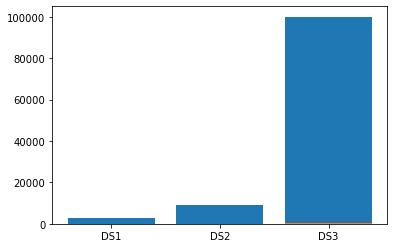

In [111]:
X= ['DS1', 'DS2','DS3']
Y=[2700,9219,100000]
z=[7.8,20.79,252]
plt.bar(X,Y)
plt.bar(X,z)